In [2]:
import numpy as np

import cv2
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy.interpolate import CubicSpline, lagrange
from scipy.optimize import curve_fit

from numpy.polynomial.polynomial import Polynomial
import random
import os
from skimage.draw import line
from scipy.ndimage import gaussian_filter1d
import skimage.morphology as morphology


import torch
from torch.distributions.gamma import Gamma

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from Solver import *
# from src.ImageClass import *
# from all import *
# from transform import *
# from draw import *

cpu


/home/sasha/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


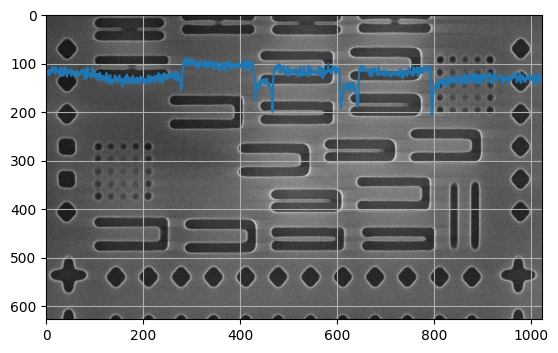

In [3]:
raw_image = cv2.imread('./Iter3_part2_E200_F015_G42_G42_C2_R1__71.tif', 0)

plt.imshow(raw_image[140:,:], cmap='gray')

plt.plot(raw_image[140,:])
plt.grid()

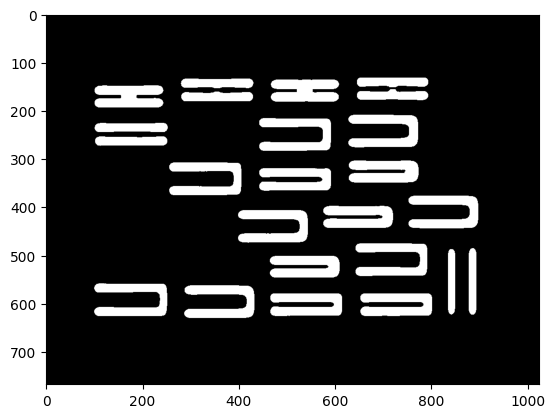

In [4]:
name = 'Iter3_part2_E200_F015_G42_G42_C2_R1__71.png'
test_image = cv2.imread(f'./{name}', 0)
test_image[:120,:] = 0
test_image[650:,:] = 0
test_image[:,:100] = 0
test_image[:,900:] = 0

plt.imshow(test_image, cmap='gray')

flag_sem_masks = True

In [5]:
def edit_bin_mask(mask):
    copy = mask.copy()
    mask_bool = mask >= 128
    mask[mask_bool] = 255
    mask[copy < 128] = 0

    kernel = np.ones((5, 5), np.uint8)  # Можно изменить размер ядра по желанию
    mask = ~mask

    opening = np.clip((morphology.remove_small_holes(mask, 10)), 0, 1) * 255
    result = opening.copy()
    result[opening == 0] = 255
    result[opening == 255] = 0
    return result.astype(np.uint8)


def detect_cont(img):
    cont, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return cont


def touch(img, first_contours, objects, i):
    temp_touch = np.zeros_like(img)
    # cv2.fillPoly(can, [objects[i].border_contour], 128)
    # if objects[i]border_contour_width == 3:
    cv2.drawContours(temp_touch, [first_contours[i]], -1, 128, 2*(objects[i].border_width))
    cv2.drawContours(temp_touch, [first_contours[i]], -1, 128, -1)
    temp_touch_2 = np.zeros_like(img)
    cv2.drawContours(temp_touch_2, [objects[i].border_contour], -1, 255, -1)
    cv2.drawContours(temp_touch_2, [first_contours[i]], -1, 128, 2*(objects[i].border_width))
    cv2.drawContours(temp_touch_2, [first_contours[i]], -1, 128, -1)

    arr = np.where((temp_touch == 0) & (temp_touch_2==255))
    if len(arr[0]) > 0:
        return True
    return False


class Figure():
    def __init__(self, hole_contour):
        self.hole_contour = hole_contour.copy()
        self.border_width = 0
        self.border_contour = hole_contour.copy()

    def getContour(self):
        return self.hole_contour
    
    def getBorderContour(self):
        return self.border_contour
    
    def init_border_contour(self, img, object, width = None):
        """ Метод, ищутся все точки контура границы и пишутся в соответсвующее поле"""
        if width is None:
            width = object.border_width
        temp = np.zeros_like(img)                     # создание временной картинки
        cv2.drawContours(temp, [object.hole_contour], 0, 1, 2*width) # рисование контура с первоначальным offset
        c, _ = cv2.findContours(temp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # детектирование контура
        object.border_contour = c[0].reshape(-1, 2).copy()

    
    def try_render(self, img, objects, object, i, width):
        """ Метод, в котором пытаешься отрендерить контур с границей и проверяешь, 
        не пересекается ли он с другими границами или объектами"""
        object.border_width = width
        self.init_border_contour(img, object)
        
        obj_num = None
        flag_render = True
        for k in range(len(objects)):
            set_cur_cont = set(map(tuple, object.border_contour))

            if k != i:
                set_another_cont = set(map(tuple, objects[k].border_contour))

                if set_cur_cont & set_another_cont:
                    obj_num = k
                    flag_render = False
                    break
        
        return obj_num, flag_render

In [6]:
def make_sem_image(img, flag_sem_masks):
    flag_touching = True
    objects = []
    first_contours = detect_cont(img)

    # отрисовываем контуры, чтобы получить все точки, создаем объекты Figure
    for contour in first_contours:
        temp = np.zeros_like(img)                     # создание временной картинки
        cv2.drawContours(temp, [contour], -1, 255, -1) # рисование контура с первоначальным offset
        c, _ = cv2.findContours(np.clip(temp, 0, 1), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)  # детектирование контура
        obj = Figure(c[0].reshape(-1, 2)) # создаем объекты класса Figure
        objects.append(obj)

    # for i, obj in enumerate(objects):
    for i in range(len(objects)):
        # m = i + 2
        if len(objects[i].hole_contour) > 1000:
            m = random.randint(3, 3)
        elif len(objects[i].hole_contour) > 600:
            m = random.randint(3, 5)
        elif len(objects[i].hole_contour) > 150:
            m = random.randint(3, 10)
        else:
            m = random.randint(3, 20)

        # flag_render = False
        break_flag = False
        for j in range(3, m + 1):
            # сначала пытаемся отрендерить с данной шириной
            # и проверяем, не пересекается ли с другими границами или объектами
            obj_num, flag_render = objects[i].try_render(img, objects, objects[i], i, j) # может быть еще что-то надо передавать
            # print('flag, bad obj num, width, max width: ', flag_render, obj_num, j, m)
            while flag_render==False:
                if j-2 >= 3: 
                    objects[i].border_width -= 2
                    obj_num, flag_render = objects[i].try_render(img, objects, objects[i], i, objects[i].border_width)
                    # print('im here, obj, flag, width = ', obj_num, flag_render, objects[i].border_width)
                    break_flag = True
                else:
                    if objects[obj_num].border_width - 2 >= 3:
                        objects[obj_num].border_width -= 2
                        objects[obj_num].init_border_contour(img, objects[obj_num])
                        obj_num, flag_render = objects[i].try_render(img, objects, objects[i], i, objects[i].border_width)
                        # print('NOW here, obj, flag = ', obj_num, flag_render)
                    else:
                        objects[i].border_width = 3
                        obj_num, flag_render = objects[i].try_render(img, objects, objects[i], i, objects[i].border_width)
                        # print('HERE, obj, flag, width = ', obj_num, flag_render, objects[i].border_width)
                        # break_flag = True
                        if obj_num is not None and objects[i].border_width == 3 and objects[obj_num].border_width == 3:
                            flag_touching = True
                        flag_render = True
                        break_flag = True

            if break_flag:
                break

    res = np.zeros_like(img)

    for i in range(len(objects)):
        bord_img_0_x = any(0 in coord for coord in zip(objects[i].border_contour[:,0]))
        bord_img_n_x = any(img.shape[1] in coord for coord in zip(objects[i].border_contour[:,0]))
        # bord_img_0_x = any(0 in coord for coord in zip(*objects[i].border_contour))
        bord_img_n_y = any(img.shape[0] in coord for coord in zip(objects[i].border_contour[:,1]))
        bord_img_0_y = any(0 in coord for coord in zip(objects[i].border_contour[:,1]))


        if bord_img_0_x or bord_img_n_x:
            objects[i] = None
            continue
        elif bord_img_0_y or bord_img_n_y:
            objects[i] = None
            continue
        else:
            # tm = np.zeros_like(img)
            # cv2.drawContours(tm , [objects[i].border_contour], -1, 128, 0)
            # cv2.drawContours(tm , [objects[i].contour], -1, 255, 0)
            # plt.imshow(tm)
            # plt.show()
            # UNCOMMENT
            if objects[i].border_width > 3:
                # print()
                after_touch = False

                # while objects[i].border_width > 1 and touch(img, first_contours, objects, i):
                temp_touch = np.zeros_like(img)
                # cv2.fillPoly(can, [objects[i].border_contour], 128)
                # if objects[i].border_width == 3:
                cv2.drawContours(temp_touch, [first_contours[i]], -1, 128, 2*(objects[i].border_width))
                cv2.drawContours(temp_touch, [first_contours[i]], -1, 128, -1)
                temp_touch_2 = np.zeros_like(img)
                cv2.drawContours(temp_touch_2, [objects[i].border_contour], -1, 255, -1)
                cv2.drawContours(temp_touch_2, [first_contours[i]], -1, 128, 2*(objects[i].border_width))
                cv2.drawContours(temp_touch_2, [first_contours[i]], -1, 128, -1)
                # fig, ax = plt.subplots(1, 2, figsize=(10,10))
                # ax[0].imshow(temp_touch)
                # ax[0].set_title('> 3 temp touch')
                # ax[1].imshow(temp_touch_2)
                # ax[1].set_title('> 3 temp touch 2')
                # plt.show()

                arr = np.where((temp_touch == 0) & (temp_touch_2==255))
                # print(arr[0])
                if len(arr[0]) > 0:
                # print('TOUCH')
                # print('> 3 ', len(objects[i].contour), objects[i].border_width)
                    temp = np.zeros_like(img)
                    cv2.drawContours(temp, [first_contours[i]], -1, 128, 2*(objects[i].border_width-2))
                    temp_cont = detect_cont(temp)
                    objects[i].border_contour = temp_cont[0].reshape(-1, 2).copy()
                    objects[i].border_width -= 2 
                cv2.drawContours(res, [first_contours[i]], -1, 128, 2*(objects[i].border_width-1))
                temp = np.zeros_like(img)
                cv2.drawContours(temp, [first_contours[i]], -1, 128, 2*(objects[i].border_width))
                zeros = np.where((temp == 255) & (res==0))
                
                if len(zeros[0]) > 0:
                    res[zeros[0][:], zeros[1][:]] = 128

            else:
                if touch(img, first_contours, objects, i) and objects[i].border_width>1:
                    temp = np.zeros_like(img)
                    # cv2.drawContours(temp, [first_contours[i]], -1, 128, 2*(objects[i].border_width-1))
                    cv2.drawContours(temp, [first_contours[i]], -1, 128, 2*(1))

                    temp_cont = detect_cont(temp)
                    objects[i].border_contour = temp_cont[0].reshape(-1, 2).copy()
                    objects[i].border_width = 1
                cv2.drawContours(res, [first_contours[i]], -1, 128, 2*(objects[i].border_width))

                temp = np.zeros_like(img)
                cv2.drawContours(temp, [first_contours[i]], -1, 128, 2*(objects[i].border_width))
                zeros = np.where((temp == 255) & (res==0))
                if len(zeros[0]) > 0:
                    res[zeros[0][:], zeros[1][:]] = 128
            cv2.drawContours(res, [first_contours[i]], -1, 255, -1)
    # cv2.imwrite(f'{semantic_path}/{file}', res.astype(np.uint8))
    return res, objects
    
    

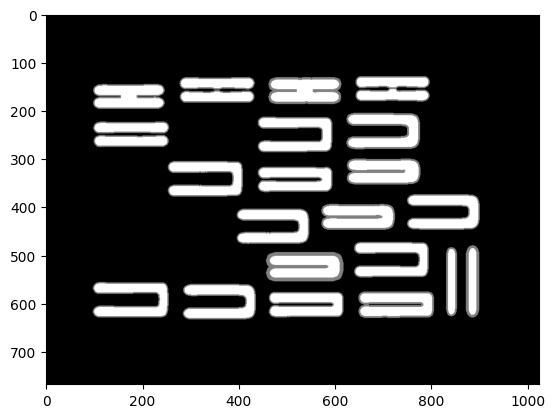

In [7]:
if flag_sem_masks:
 sem_image, objects = make_sem_image(test_image, flag_sem_masks)

cv2.imwrite(f'./{name[:-4]}_sem.png', sem_image.astype(np.uint8))
plt.imshow(sem_image, cmap='gray')

Теперь по идее можно сканировать по линиям слева направо и сверху вниз и писать длину белого фрагмента

In [8]:
row_width = np.zeros_like(sem_image, dtype=np.uint8)
for row in range(sem_image.shape[0]):
    white_pixels = np.argwhere(sem_image[row,:] == 255)
    for pixel in white_pixels:
        if sem_image[row,pixel-1] == 128:
            start = pixel
        elif sem_image[row,pixel+1] == 128:
            end = pixel
            row_width[row, start[0]:end[0]] = len(row_width[row, start[0]:end[0]])


column_width = np.zeros_like(sem_image, dtype=np.uint8)
for col in range(sem_image.shape[1]):
    white_pixels = np.argwhere(sem_image[:,col] == 255)
    for pixel in white_pixels:
        if sem_image[pixel-1, col] == 128:
            start = pixel
        elif sem_image[pixel+1, col] == 128:
            end = pixel
            column_width[start[0]:end[0], col] = len(column_width[start[0]:end[0], col])

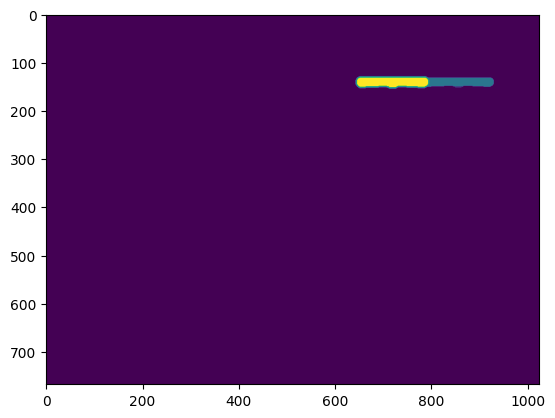

In [10]:
for i in range(len(objects)):
    temp = np.zeros_like(sem_image)
    cv2.drawContours(temp, [objects[i].border_contour], -1, 128, -1)
    cv2.drawContours(temp, [objects[i].hole_contour], -1, 255, -1)

    hole_mask = cv2.inRange(temp, 255, 255)
    object_width_horizontal = cv2.bitwise_and(hole_mask, row_width)
    object_width_vertical = cv2.bitwise_and(hole_mask, column_width)

    wider_part = np.clip(object_width_horizontal > object_width_vertical,0,255)
    wider_part[wider_part==1]=255
    # print(wider_part.shape)
    shifting_contour = detect_cont(wider_part.astype(np.uint8))
    for contour in shifting_contour:

    # shifted_contour = shifting_contour + np.array([10, 0])
        shifted_contour = contour.copy()  # Создаем копию контура
        shifted_contour[:, 0, 0] += object_width_horizontal.max() - 10
        cv2.drawContours(temp, [shifted_contour], -1, 100, -1)

        cv2.drawContours(temp, [objects[i].border_contour], -1, 128, -1)
        cv2.drawContours(temp, [objects[i].hole_contour], -1, 255, -1)
plt.imshow(temp)
    # plt.imshow(contour_for_shifting)
    # break




1


1
Processing time: 0.4179866313934326 [sec]


True

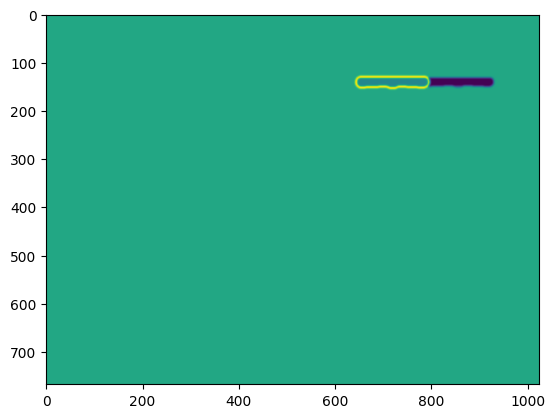

In [48]:
for i in range(len(objects)-1,len(objects)):
    temp = np.zeros_like(sem_image)
    cv2.drawContours(temp, [objects[i].border_contour], -1, 128, -1)
    cv2.drawContours(temp, [objects[i].hole_contour], -1, 255, -1)
    
    hole_mask = cv2.inRange(temp, 255, 255)
    object_width_horizontal = cv2.bitwise_and(hole_mask, row_width)
    object_width_vertical = cv2.bitwise_and(hole_mask, column_width)

    wider_part = np.clip(object_width_horizontal > object_width_vertical,0,255)
    wider_part[wider_part==1]=255
    # print(wider_part.shape)
    shifting_contour = detect_cont(wider_part.astype(np.uint8))
    temp = np.zeros_like(sem_image)

    for contour in shifting_contour:

    # shifted_contour = shifting_contour + np.array([10, 0])
        shifted_contour = contour.copy()  # Создаем копию контура
        shifted_contour[:, 0, 0] += object_width_horizontal.max() - 10
        cv2.drawContours(temp, [shifted_contour], -1, 100, -1)

    cv2.drawContours(temp, [objects[i].border_contour], -1, 128, -1)
    cv2.drawContours(temp, [objects[i].hole_contour], -1, 255, -1)

    solv = Solver(algo='algo1', signal_formula='formula_k', pixel_size=12, resist_thickness=700, k=0.125, E=25, \
                    masks=[temp],dp2=(0,1), dp3=(1,0))
    print(solv.mask_objects)
    # break
plt.imshow(solv.mask_objects[0].signal)

cv2.imwrite('./tested_signal.png', solv.mask_objects[0].signal.astype(np.uint8))

In [71]:
for i in range(len(objects)):
    temp = np.zeros_like(sem_image)
    cv2.drawContours(temp, [objects[i].border_contour], -1, 128, -1)
    cv2.drawContours(temp, [objects[i].hole_contour], -1, 255, -1)

    hole_mask = cv2.inRange(temp, 255, 255)
    object_width_horizontal = cv2.bitwise_and(hole_mask, row_width)
    object_width_vertical = cv2.bitwise_and(hole_mask, column_width)

    wider_part = np.clip(object_width_horizontal > object_width_vertical,0,255)
    wider_part[wider_part==1]=255
    # print(wider_part.shape)
    shifting_contour = detect_cont(wider_part.astype(np.uint8))
    temp = np.zeros_like(sem_image)

    for contour in shifting_contour:

    # shifted_contour = shifting_contour + np.array([10, 0])
        shifted_contour = contour.copy()  # Создаем копию контура
        shifted_contour[:, 0, 0] += object_width_horizontal.max() - 10
        cv2.drawContours(temp, [shifted_contour], -1, 100, -1)
    cv2.drawContours(temp, [objects[i].border_contour], -1, 128, -1)
    cv2.drawContours(temp, [objects[i].hole_contour], -1, 255, -1)  
    # break

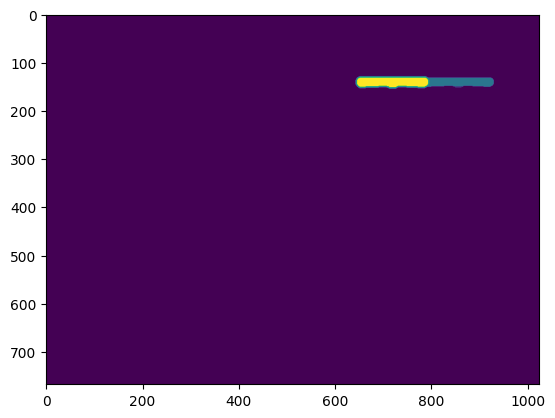

In [76]:
plt.imshow(temp)

True

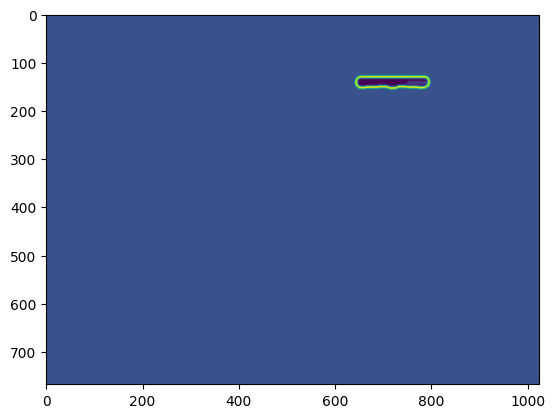

In [69]:
solv.mask_objects[0].angles_map[140:145,750:800] = 1.5
solv.mask_objects[0].color_map[140:145,750:800] = 110


signal = solv.GetSignal(solv.mask_objects[0])

plt.imshow(signal)
cv2.imwrite('./flashing_hole.png', signal.astype(np.uint8))

True

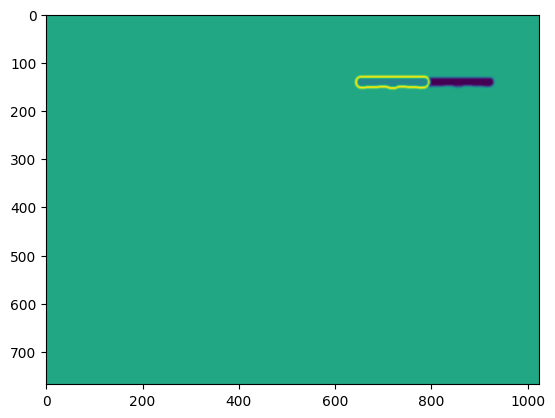

In [79]:
solv.mask_objects[0].mask[solv.mask_objects[0].mask==100] = 0
solv.mask_objects[0].angles_map[140:145,800:] = 1.5
# solv.mask_objects[0].color_map[140:145,800:]
# 
signal = solv.GetSignal(solv.mask_objects[0])

plt.imshow(signal)
cv2.imwrite('./flashing_back.png', signal.astype(np.uint8)) 

In [77]:
temp[temp==100] = 0

In [14]:
# solv.mask_objects[0].color_map[temp==100] = (solv.mask_objects[0].color_map[temp==128].mean())
solv.mask_objects[0].color_map[temp==100] = solv.mask_objects[0].color_map[temp==128].mean()

# solv.mask_objects[0].angles_map[temp==100] = solv.mask_objects[0].angles_map[temp==128].mean()


In [21]:
np.unique(solv.mask_objects[0].color_map[temp==128])

array([85.], dtype=float32)

In [16]:
solv.mask_objects[0].color_map[temp==128].max()

110.0

In [17]:
np.unique(solv.mask_objects[0].angles_map[temp==100])

np.unique(solv.mask_objects[0].color_map[temp==100])


array([110.], dtype=float32)

In [21]:
solv.mask_objects[0].color_map[temp==100] = solv.mask_objects[0].color_map[temp==128].max()

solv.mask_objects[0].angles_map[temp==100] = solv.mask_objects[0].angles_map[temp==100] + 1


In [73]:
solv = Solver(algo='algo1', signal_formula='formula_k', pixel_size=12, resist_thickness=700, k=0.125, E=25, \
                  masks=[temp.copy()],dp2=(0,1), dp3=(1,0))

1
1
Processing time: 0.41065502166748047 [sec]


True

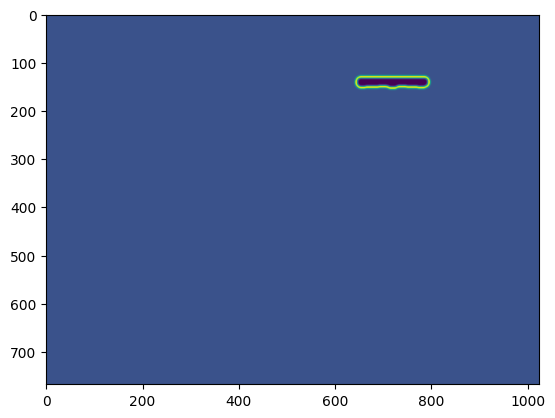

In [62]:
plt.imshow(solv.mask_objects[0].signal)
cv2.imwrite('./signal_original.png', solv.mask_objects[0].signal.astype(np.uint8))

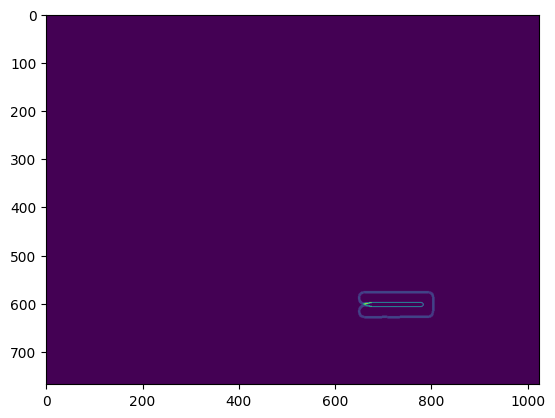

In [47]:
plt.imshow(solv.mask_objects[0].angles_map)
plt.imshow(solv.mask_objects[0].color_map)
plt.imshow(solv.mask_objects[0].width_map)



In [36]:
signal = solv.GetSignalk(solv.mask_objects[0].mask, solv.mask_objects[0].angles_map, solv.mask_objects[0].color_map)
signal[temp==100] = signal[temp==0].max() + 10
# signal[temp==255] = signal[temp==255].max() + 10
signal = np.clip(cv2.GaussianBlur(signal, (11,11), 0), 0, 255)

In [38]:
solv.mask_objects[0].color_map[temp==100] = solv.mask_objects[0].color_map[temp==0].max() + 10
solv.mask_objects[0].color_map[temp==255] = solv.mask_objects[0].color_map[temp==255].max() + 10

solv.mask_objects[0].mask[temp==100] = 0

In [39]:
signal = solv.GetSignal(solv.mask_objects[0])


True

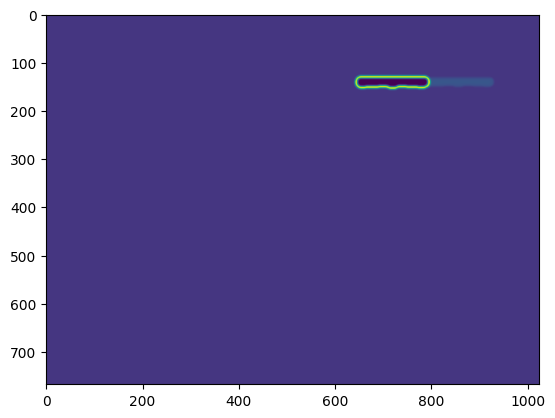

In [40]:
plt.imshow(signal)
cv2.imwrite('./signal_flashing1.png', signal.astype(np.uint8))
# solv.mask_objects[0].signal[temp==100] = solv.mask_objects[0].signal[temp==128].min()

# plt.imshow(solv.mask_objects[0].signal)
# cv2.imwrite('./signal_flashing.png', solv.mask_objects[0].signal.astype(np.uint8))

In [ ]:
cv2.imwrite('./signal_test.png', solv.mask_objects[0].signal.astype(np.uint8))

True

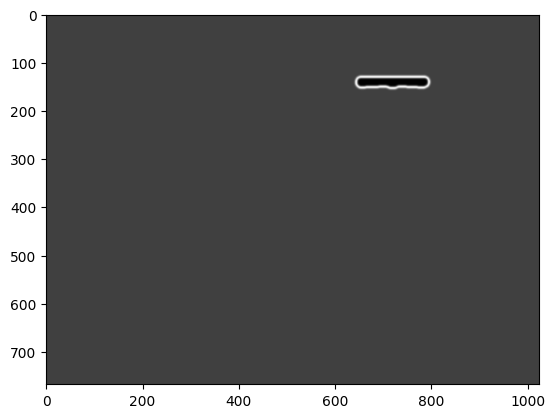

In [ ]:
plt.imshow(solv.mask_objects[0].signal, cmap='gray')